# USG grants crawl
## Open Science Overview

### Previously

In the previous chapter we loaded the [grants.gov](https://www.grants.gov/web/grants) grants database and looked at some summary characteristics of what it conatined.

In this chapter we'll move on to looking at the available data with the goal of learning more about how government grant solicitations might be targeting open Science

### Loading the database once more

Let's begin by loading up the database provided by the website, which is stored in an xml format.

In [1]:
from bs4 import BeautifulSoup
import xmltodict
import sys

# FUTURE NOTE: it may be possible to do a check for a local file meeting the relevant criterion and conditionally 
# download from https://www.grants.gov/extract/ (and extract compressed file) in the event a local target isn't found.
# For the moment though...

# load up the xml file; hard-path to local file.  Adjust as necessary
pathToXML='C://Users//dbullock//Documents//code//gitDir//USG_grants_crawl//inputData//GrantsDBExtract20230113v2.xml'

# open and parse file
with open(pathToXML, 'r') as f:
    govGrantData_raw = f.read()

# convert xml to dictionary
with open(pathToXML) as xml_file:
    govGrantData_dictionary = xmltodict.parse(xml_file.read())

# quick size legibility function generated by code-davinci-002
def convert_bytes(bytes):
    if bytes < 1024:
        return str(bytes) + " B"
    elif bytes < 1048576:
        return str(round(bytes/1024, 1)) + " KB"
    elif bytes < 1073741824:
        return str(round(bytes/1048576, 1)) + " MB"
    elif bytes < 1099511627776:
        return str(round(bytes/1073741824, 1)) + " GB"
    else:
        return str(round(bytes/1099511627776, 1)) + " TB"
    
# terminal reports
print('Dictionary conversion successful')
print('\n' + str(len(govGrantData_dictionary['Grants']['OpportunitySynopsisDetail_1_0'])) + ' grant entries found, totalling '+ convert_bytes(sys.getsizeof(govGrantData_raw)))
print('\n and with dictionary keys:\n')
print(govGrantData_dictionary['Grants']['OpportunitySynopsisDetail_1_0'][0].keys())

Dictionary conversion successful

70330 grant entries found, totalling 256.2 MB

 and with dictionary keys:

dict_keys(['OpportunityID', 'OpportunityTitle', 'OpportunityNumber', 'OpportunityCategory', 'FundingInstrumentType', 'CategoryOfFundingActivity', 'CategoryExplanation', 'CFDANumbers', 'EligibleApplicants', 'AdditionalInformationOnEligibility', 'AgencyCode', 'AgencyName', 'PostDate', 'CloseDate', 'LastUpdatedDate', 'AwardCeiling', 'AwardFloor', 'EstimatedTotalProgramFunding', 'ExpectedNumberOfAwards', 'Description', 'Version', 'CostSharingOrMatchingRequirement', 'ArchiveDate', 'GrantorContactEmail', 'GrantorContactEmailDescription', 'GrantorContactText'])


### How do we find "Open Science Infrastructure"-related grants?

How can we tell which of these grants are related to Open Science Infrastructure?  The 'Description' of the grant records that the database contains provides a potential target for filtering the grants.  If we can find a way to use the information contained within the description to determine whether or not the grant is related to this topic, we might be able to limit our consideration to this subset, and thereby be able to make insights about its characteristics.

#### With a simple keyword search

We can make a first, naieve attempt at this by using a word-bank with words or phrases that we believe are likely to show up in a grant relevant to open science infrastructure (e.g. 'metadata', 'FAIR', 'data sharing', etc.).  In this repository we have just such a word-bank already available (in 'keywords.txt'), but users should feel free to update and/or augment it as they see fit.

To begin then, we'll do a quick search to see how many grants each of the word-bank terms comes up in.

C:\Users\dbullock\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


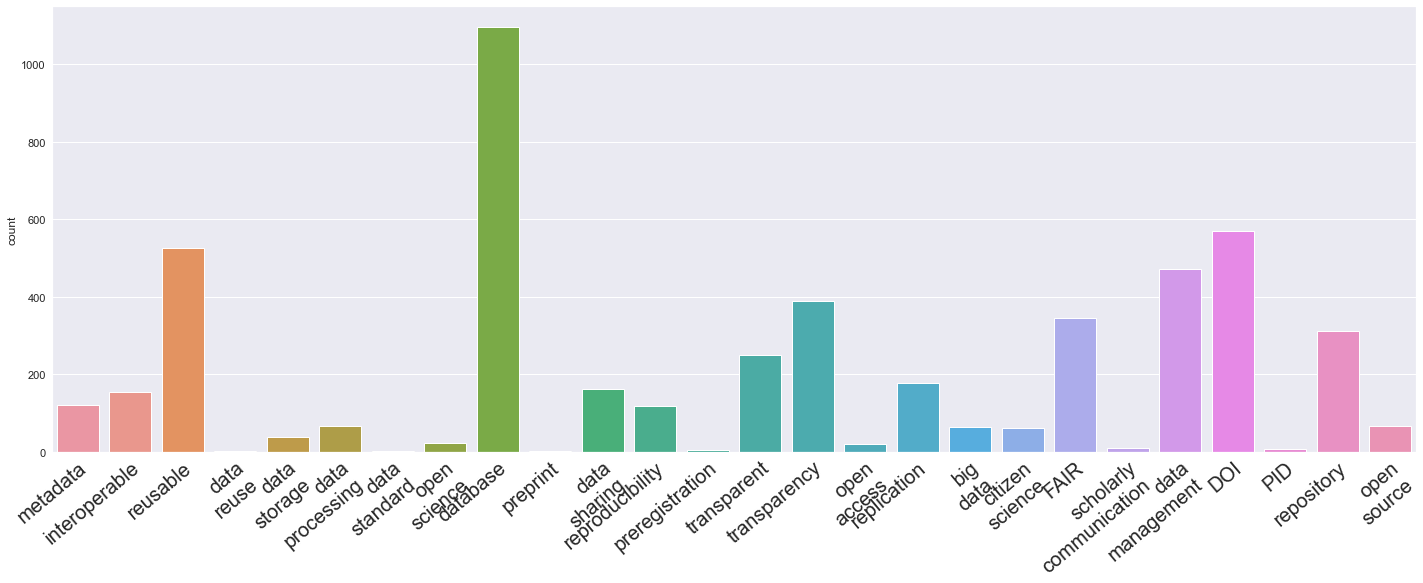

In [6]:
import json
import seaborn as sns
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import re

# open the keywords file
with open('keywords.txt', 'r') as f:
    keywords = f.read()

# split it into a list.  Each term is kept on a separate line
keywords=keywords.split('\n')

# create a dictionary which will be saved as a json, so that you don't have to do this each time
grantFindsOut={}

# iterate through the keywords
for iKeywords in keywords:
    # create a blank list to store the IDs of the grants with the keyword in the description
    grantsFound=[]
    compiledSearch=re.compile('\\b'+iKeywords.lower()+'\\b')
    for iListing in govGrantData_dictionary['Grants']['OpportunitySynopsisDetail_1_0']:
        # maybe it doesn't have a description field
        try:
            # case insensitive find for the keyword
            if bool(compiledSearch.search(iListing['Description'].lower().replace('-',''))):
                #append the ID if found
                grantsFound.append(iListing['OpportunityID'])
        except:
            # do nothing, if there's no description field, then the word can't be found
            pass
            
    # store the found entries in the output dictionary.  Use the keyword as the key (with spaces replaced with underscores),
    # and the value being the list of grant IDs
    grantFindsOut[iKeywords.replace(' ','_')]=grantsFound

# save it out
with open("grantFindsOut.json", "w") as outfile:
    json.dump(grantFindsOut, outfile)
    
# plot a histogram
#silly way to do this, but seaborn was giving me issues
import itertools
keywordCountVec=[]
for iKeywords in list(grantFindsOut.keys()):
    currVec=[iKeywords.replace('_','\n')] * len(grantFindsOut[iKeywords])
    keywordCountVec.extend(currVec)

import seaborn as sns
keywordHistDF=pd.DataFrame(data=keywordCountVec, columns=['keyword'])
#keywordHistDF.loc[0:10]=[len(grantFindsOut[iKeyword]) for iKeyword in grantFindsOut.keys()]
#keywordHistDF
sns.set(rc={'figure.figsize':(20,8.27)})
ax=sns.countplot(keywordCountVec)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",rotation_mode='anchor',fontsize=20)
#ax.set_yticklabels(ax.get_yticklabels(),fontsize=20)
ax.tick_params(axis='both', which='major', pad=0)
plt.tight_layout()
plt.show()

#### The resulting plot

In the resulting plot we get a rough sense of how frequently these terms are coming up.  Admittedly, we don't actually know the context in which these terms are being used, so it's quite possible that they are being used with a different meaning in mind (e.g. fair).  That being said, it's a only starting point, and maybe we can do better.

### Co-occurance

Perhaps it's not sufficient to know if _any_ of the relevant terms shows up in the gant description.  Maybe instead, we might want to require some number or subset of these terms to co-occur to help ensure that we're actually targeting relevant grants.  To consider this, we would want to look at which of these terms occur together and how frequently they do so.

Lets start with a basic matrix plot of these relations.

<AxesSubplot:>

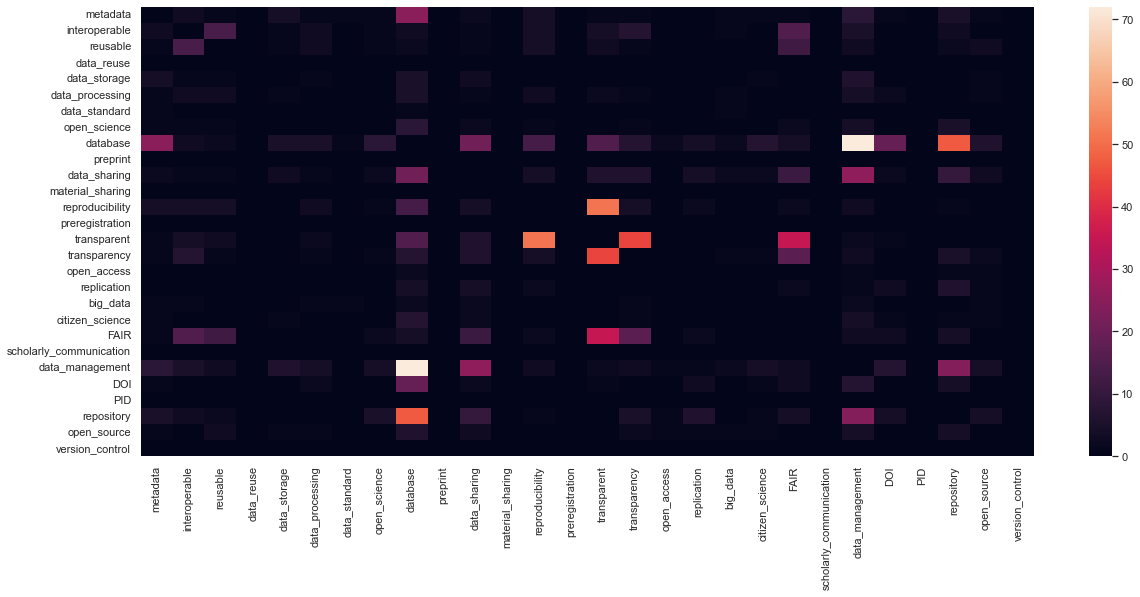

In [3]:
import numpy as np
import copy
# ok, lets create a matrix that holds co-occurance data
# let's start by making a blank matrix to hold the data
connectivityMatrix=np.zeros((len(grantFindsOut.keys()),len(grantFindsOut.keys())), dtype=np.int32())
# also make a list to hold the rows from this
dfRowContentAll=[]
# should be symmetric so x and y doesn't really matter
# use this opportunity to get the indexes of the lower triangle though
lowerTriIndices = [list(x) for x in np.tril_indices_from(connectivityMatrix)]
#convert this to the format we need
lowerTriList=[[lowerTriIndices[0][iIndex],lowerTriIndices[1][iIndex]] for iIndex in range(len(lowerTriIndices[0]))]
# iterate across both axes

for iIndexX, iKeywordsX in enumerate(list(grantFindsOut.keys())):
    for iIndexY, iKeywordsY in enumerate(list(grantFindsOut.keys())):
        # get the values for each "node" (e.g. the grant IDs for each keyword)
        IDsX=grantFindsOut[iKeywordsX]
        IDsY=grantFindsOut[iKeywordsY]
        # find the intersection
        intersectionGrants=list(set(IDsX) & set(IDsY))
        # find the size of that intersection
        sharedGrantNum=len(intersectionGrants)
        connectivityMatrix[iIndexX,iIndexY]=sharedGrantNum
        # do components for dataframe

        if not [iIndexX,iIndexY] in lowerTriList:
            print 
            
            if iKeywordsX==iKeywordsY:
                # half it for the visualization for self connections
                #dfRowContent=[iKeywordsX, iKeywordsY, np.divide(sharedGrantNum,2).astype(np.int32)]
                # or set it to zero
                dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')' , 0]
            else:
                dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')', sharedGrantNum]
            dfRowContentAll.append(dfRowContent)

flatConMatrix=pd.DataFrame(data=dfRowContentAll, columns=['keyword1','keyword2','value'])

# mask out the diagonal so it doesn't overwhelm the plot
diagonalMask=np.eye(len(list(grantFindsOut.keys())),dtype=bool)
# copy the matrix so it can be modified 
plotMatrix=copy.deepcopy(connectivityMatrix)
# set the diagonal to zero
plotMatrix[diagonalMask]=np.zeros(len(list(grantFindsOut.keys())))
                    

sns.heatmap(data=plotMatrix,yticklabels=list(grantFindsOut.keys()),xticklabels=list(grantFindsOut.keys()))

#### A different view

The above matrix plot provides a good sense of the quantative characteristics of term co-occurance in the grants.  However, this sort of visualization may not completely encapsulate the overall patterns that we may be looking for.  For an alternate perspective we can try a chord diagram.

NOTE:  The code block below makes use of [d3blocks](https://github.com/d3blocks/d3blocks), which is a python package that is unlikely to be installed by default.  Also note, that this code block will open up a new window with the resulting figure.

In [4]:
from d3blocks import D3Blocks
import os
# Initialize
d3 = D3Blocks()
# change the column names to what's required by d3blocks
# https://d3blocks.github.io/d3blocks/pages/html/Chord.html
flatConMatrix=flatConMatrix.rename(columns={"keyword1": "source", "keyword2": "target", 'value': 'weight'})
# notebook= True doesn't seem to work
# d3.chord(flatConMatrix,filepath=None,notebook=True)
d3.chord(flatConMatrix, showfig=False,filepath='./d3blocks.html')

import IPython
IPython.display.IFrame('d3blocks.html',height=900,width=1000)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [C:\Users\dbullock\Documents\code\gitDir\USG_grants_crawl\d3blocks.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [C:\Users\dbullock\Documents\code\gitDir\USG_grants_crawl\d3blocks.html]
